In [1]:
import dask.dataframe as dd
import torch
from src.data.storage import dd_read_parquet
from src.data.config import DATASET

In [2]:
ddf = dd_read_parquet(DATASET.local_path)
ddf = ddf.repartition(npartitions=10)  # simulate bigger dataset

In [3]:
index = ddf.index.compute()

In [4]:
from PIL import Image
from io import BytesIO
from src.data.storage import get_S3_fs


def read_image(path: str, remote: bool = False) -> Image:
    if remote:
        S3 = get_S3_fs()
        with S3.open(path, mode="rb") as f:
            img_bytes = f.read()
        return Image.open(BytesIO(img_bytes)).convert("RGB")
    else:
        return Image.open(path).convert("RGB")

In [5]:
i = 0
idx = index[i]
row = ddf.loc[idx, :].compute()
d = {
    "img": read_image(row.loc[idx, "imgPath"], remote=True),
    "txt": row.loc[idx, "txt"],
    "coords": torch.Tensor([row.loc[idx, "lat"], row.loc[idx, "lon"]]),
    "label": torch.Tensor([row.loc[idx, "price_fractional"]]).long(),
}

In [6]:
from torchvision import transforms

img_transform = transforms.Compose(
    [
        transforms.Resize(size=(224, 224)),
        transforms.ToTensor(),
        # transforms.Normalize(
        #     mean=[0.485, 0.456, 0.406],
        #     std=[0.229, 0.224, 0.225],
        # )
    ]
)

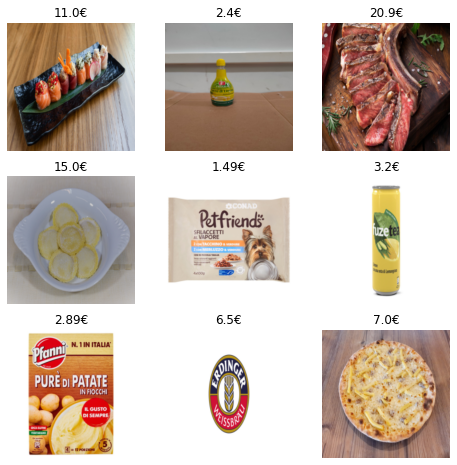

In [7]:
import matplotlib.pyplot as plt
from src.models.utils.data import FoodPricingDataset

training_data = FoodPricingDataset(
    img_transform=img_transform, txt_transform=lambda x: x
)

figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(training_data), size=(1,)).item()
    sample = training_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(f"{sample['label'].numpy()[0] / 100}€")
    plt.axis("off")
    plt.imshow(sample["img"].permute(1, 2, 0))
plt.show()

In [8]:
dev_len = test_len = int(len(training_data) // 7.5)
train_len = len(training_data) - dev_len - test_len
train, dev, test = torch.utils.data.random_split(
    training_data, [train_len, dev_len, test_len]
)

In [9]:
for n, i in enumerate(training_data.iter_txt(train.indices)):
    if n > 4:
        break
    print(i)

125. Riso con manzo Riso saltato con carne di manzo piselli uovo
I Favati Aglianico Campi Taurasini DOC 75cl nan
Valmarone 75cl nan
Ebi gong bao Gamberi con peperoni cipolle e salsa piccante
Menù MAXI x 4 Scegli 4 gusti di pizza a piacere + 4 supplì
